In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML

from Modules import BasicTools as BT
from Modules import WaveTools as WT
from Modules import PlotTools as PT
from Modules import FFTTools as FFTT
from Modules import OperatorTools as OT
from Modules import GridTransferTools as GTT
from Modules import TestTools as TT
from Modules import SolverTools as ST

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 10000, threshold = 100000)

In [2]:
nh_min = 32
refRatio = 2
CFL = 1.
c = 1.
nt = 42

In [3]:
finehalf = list(np.arange(int(nh_min / refRatio)) + int(nh_min / refRatio))
omega = BT.Grid(nh_min)
omega.AddPatch(refRatio, finehalf)
nh_max = omega.nh_max
degFreed = omega.degFreed
omegaF = BT.Grid(nh_max)
t, nt = ST.CalcTime(omega, CFL, c, nt = nt)

In [4]:
waves = WT.MakeWaves(omega)
wavesF = WT.MakeWaves(omegaF)
# PT.PlotWaves(omega, waves = waves)

In [5]:
restrictOp = GTT.CoarsenOp(omega)
print(restrictOp)

[[0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.5 0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

In [6]:
# def PropRestrictWaves(omega, waveform):
#     nh_max = omega.nh_max
#     waves = WT.MakeWaves(omega)
#     omegaF = BT.Grid(nh_max)
#     wavesF = WT.MakeWaves(omegaF)
#     nullspace = OT.FindNullspace(omega, waves)
#     restrictOp = GTT.CoarsenOp(omega)
#     FCoefs = FFTT.FourierCoefs(omegaF, wavesF, waveform)
#     propWaves = FFTT.PropWaves(omegaF, wavesF, c, t)
#     propWaveform = restrictOp @ propWaves @ FCoefs
#     propFCoefs = FFTT.FourierCoefs(omega, waves @ nullspace, propWaveform)
#     return propFCoefs

In [7]:
nullspace = OT.FindNullspace(omega, waves)

sqStart = int(nh_min / 8)
sqEnd = int(((2 * nh_min) / 8) + 2)
print(sqStart, sqEnd)
waveform = np.zeros(nh_max, float)
waveform[sqStart:sqEnd] = 1

# FCoefs = FFTT.FourierCoefs(omegaF, wavesF, waveform)
# propWaves = FFTT.PropWaves(omegaF, wavesF, c, t)
# propWaveform = restrictOp @ propWaves @ FCoefs
# propFCoefs = FFTT.FourierCoefs(omega, waves @ nullspace, propWaveform)
propFCoefs = FFTT.PropRestrictWaves(omega, waveform, c, t)
waveform = restrictOp @ waveform
FCoefs = FFTT.FourierCoefs(omega, waves @ nullspace, waveform)

# solverCoefs = ST.RK4(omega, waves @ nullspace, waveform, nt, c, CFL, ST.Upwind)

oldPropWaves = FFTT.PropWaves(omega, waves, c, t)
newWaveform = oldPropWaves @ nullspace @ FCoefs
oldPropFCoefs = FFTT.FourierCoefs(omega, waves @ nullspace, newWaveform)
labels = [r'$u_{0} (x)$', r'Exact $u_{0} (x - c t)$']
allCoefs = PT.Load(FCoefs, propFCoefs)
print(np.shape(allCoefs))

4 10
(48, 2)


Are you *sure* your labels are ordered correctly?


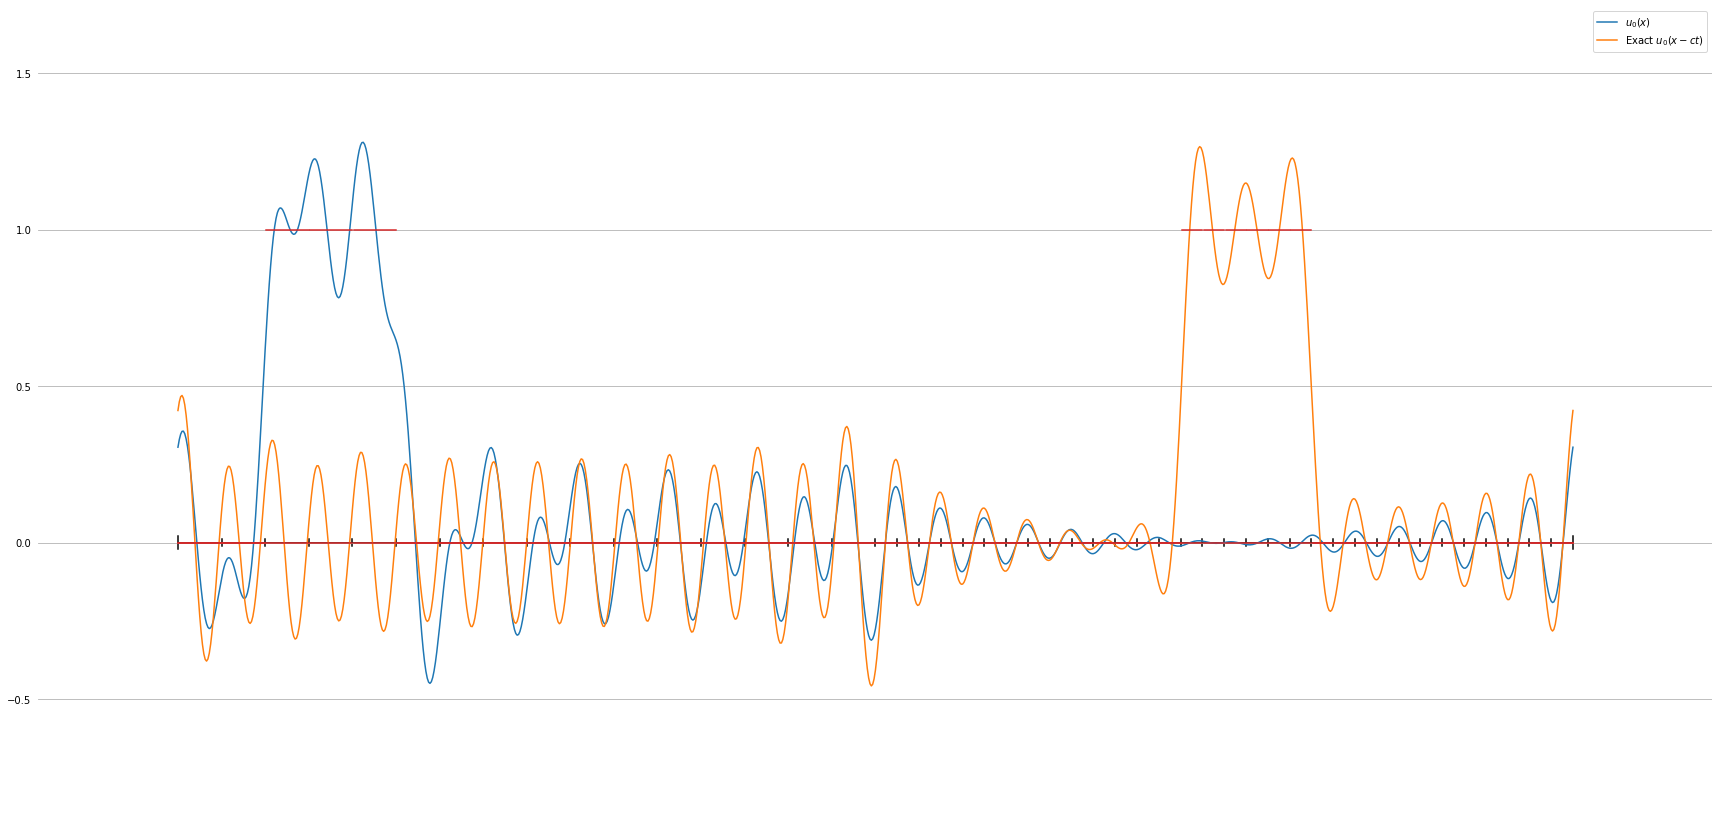

In [8]:
PT.PlotMixedWave(omega, waves, nullspace @ allCoefs, rescale = 6, labels = labels, yGrid = True)#, saveName = 'Step' + str(nt))


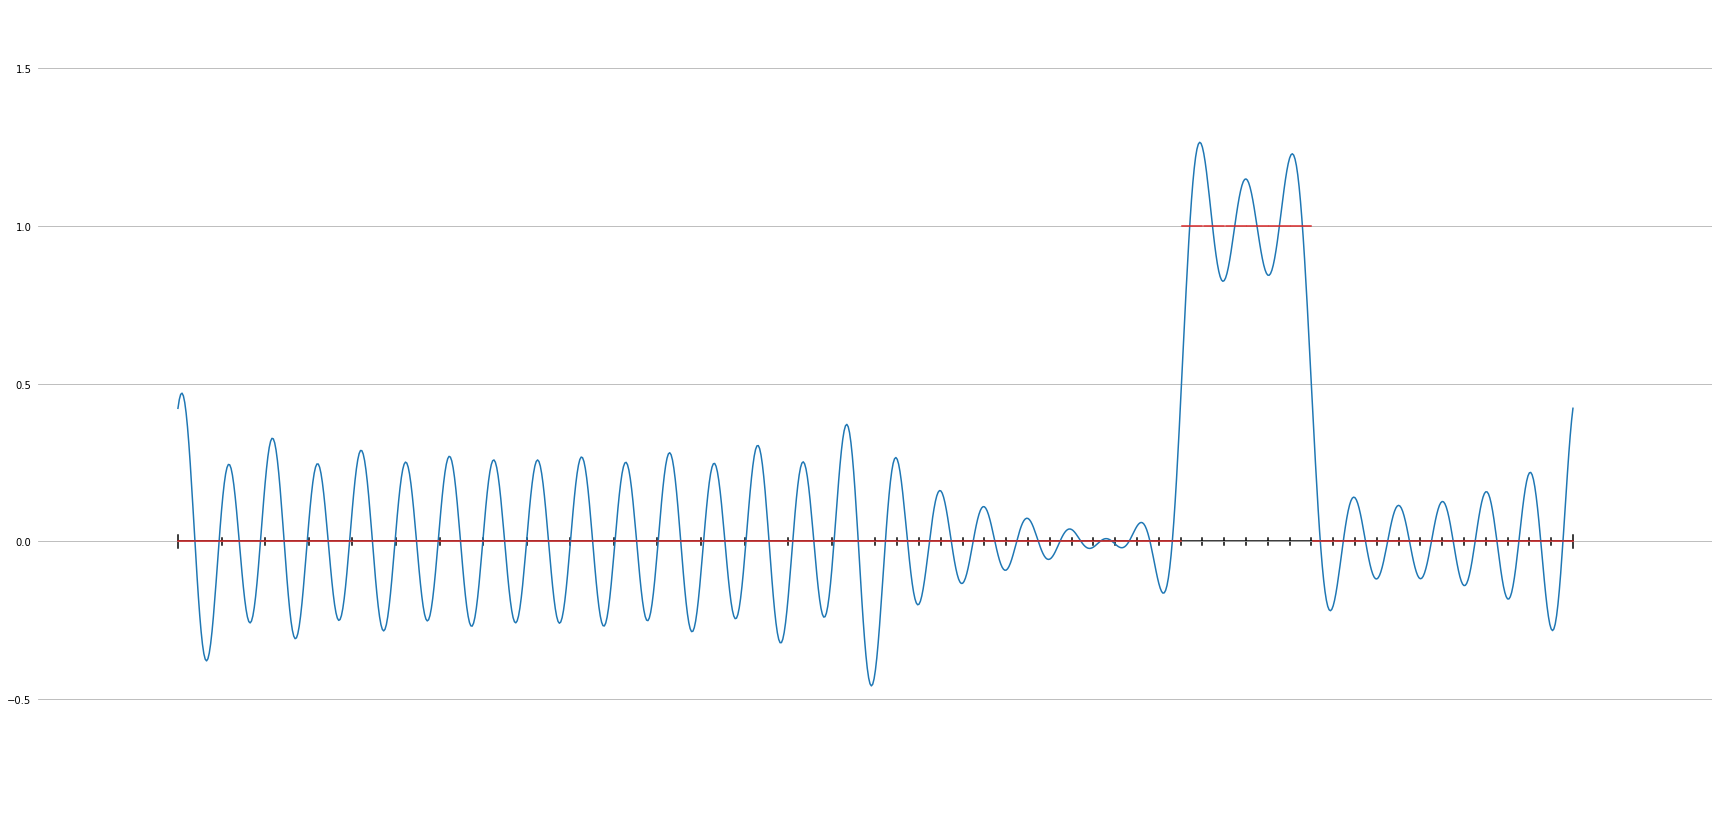

In [9]:
PT.PlotMixedWave(omega, waves, nullspace @ propFCoefs, rescale = 6, labels = ['new'], yGrid = True)#, saveName = 'Step' + str(nt))


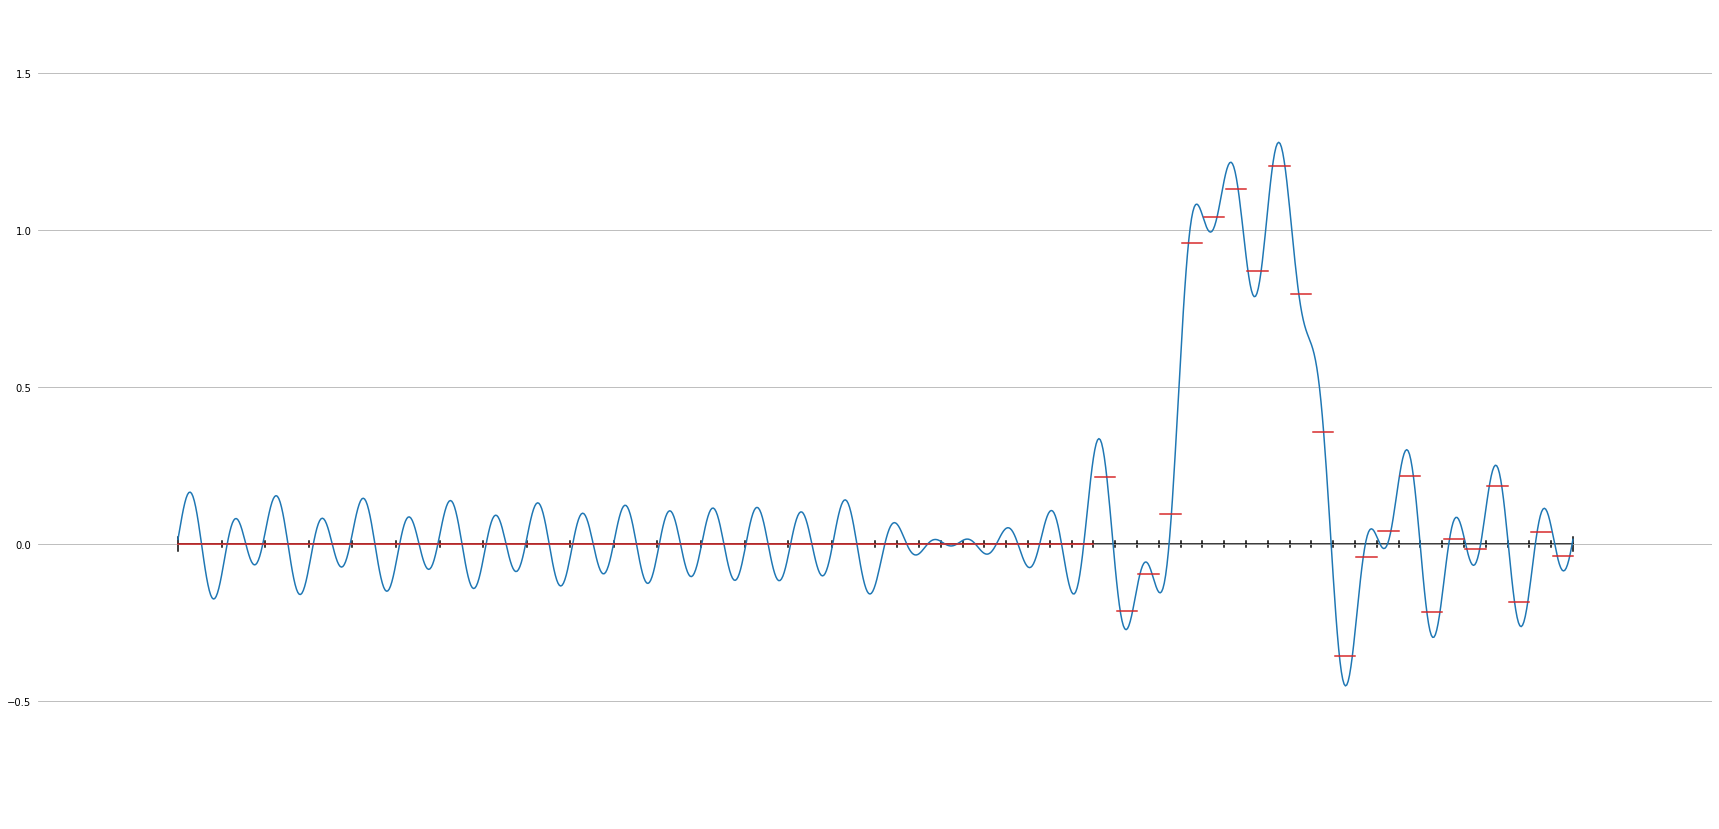

In [10]:
PT.PlotMixedWave(omega, waves, nullspace @ oldPropFCoefs, rescale = 6, labels = ['old'], yGrid = True)#, saveName = 'Step' + str(nt))


In [11]:
hs = omega.h
print(hs)


[0.03125  0.03125  0.03125  0.03125  0.03125  0.03125  0.03125  0.03125  0.03125  0.03125  0.03125  0.03125  0.03125  0.03125  0.03125  0.03125  0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625 0.015625]


In [12]:
n = 20
A = np.ones(n)
A[5:10] = 0.5
A[15:] = 0.5
print(A)
print(np.roll(A, 1))



B = A - np.roll(A, 1)
B[B > 0] = 0.5
B[B < 0] = 2. / 3.
C = B + np.roll(B, -1)
D = np.roll(B, -1)
D[D != 2. / 3.] = 0
C = C - D
B[B < 2. / 3.] = 1.
C[C == 0] = 1.
C = -C
# B = A - np.roll(A, 1)
# B[B > 0] = 0.5
# B[B < 0] = 2. / 3.
# C = -np.roll(B, -1) - np.roll(B, -2)
# D = np.roll(B, -2)
# D[D != 2. / 3.] = 0
# C = C + D
# B[B < 2. / 3.] = 1
# # C[C == 2. / 3.] = 1.
# C[C == 0] = -1.
print(B)

print(C)


print('')
M = np.zeros((n, n), float)
np.fill_diagonal(M, B)
np.fill_diagonal(M[1:], C)
M[0, n - 1] = C[::-1][0]
# print(M)

[1.  1.  1.  1.  1.  0.5 0.5 0.5 0.5 0.5 1.  1.  1.  1.  1.  0.5 0.5 0.5 0.5 0.5]
[0.5 1.  1.  1.  1.  1.  0.5 0.5 0.5 0.5 0.5 1.  1.  1.  1.  1.  0.5 0.5 0.5 0.5]
[1.         1.         1.         1.         1.         0.66666667 1.         1.         1.         1.         1.         1.         1.         1.         1.         0.66666667 1.         1.         1.         1.        ]
[-0.5        -1.         -1.         -1.         -1.         -0.66666667 -1.         -1.         -1.         -0.5        -0.5        -1.         -1.         -1.         -1.         -0.66666667 -1.         -1.         -1.         -0.5       ]

